# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

# statistics
from scipy.stats import ttest_ind

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

### In all the plots we are using colorblind-friendly colors from [this](https://davidmathlogic.com/colorblind/#%23FFC20A-%230C7BDC) website

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create columns `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create columns `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created columns for paper `P17`.
- Print the resulting dataframe.

In [2]:
df_reviews = pd.read_json("./data/acl18_v1_numerical_final.json").reset_index(drop=True)

In [4]:
# helper function to use later on as argument to the pandas 'apply' fucntion
def get_overall_score(x, col, mean):
    '''
    x: one row/paper of the data frame 
    col: column/feature we want to use from the data frame  
    mean: boolean (1 or 0) if set to 1 the function will return mean, else it will return std 
    returns: the average_overall_score for this row/paper
    '''
    x_dict = dict(x[col])
    overall_scores = []
    # iterate on the reviews and get the given overall score
    for k in x_dict.keys():
        overall_scores.append(x_dict[k]["scores"]["overall_score"])
        
    return np.mean(overall_scores) if mean else np.std(overall_scores)

# create the required columns 
df_reviews["overall_score_before_avg"] = df_reviews.apply(
    lambda x: get_overall_score(x, col = "scores_before", mean=1), axis=1
)
df_reviews["overall_score_after_avg"] = df_reviews.apply(
    lambda x: get_overall_score(x, col = "scores_after", mean=1), axis=1
)
df_reviews["overall_score_before_std"] = df_reviews.apply(
    lambda x: get_overall_score(x, col = "scores_before", mean=0), axis=1
)
df_reviews["overall_score_after_std"] = df_reviews.apply(
    lambda x: get_overall_score(x, col = "scores_after", mean=0), axis=1
)

# print the four newly created columns for paper P17
display(df_reviews[df_reviews["tmp_id"] == "P17"][['overall_score_before_avg', 'overall_score_after_avg', 
                                           'overall_score_before_std', 'overall_score_after_std']])

,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
16,4.5,4.5,0.5,0.5


In [5]:
#print the resulting df
display(df_reviews)

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,2.500000,0.500000,0.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,3.333333,0.942809,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,4.666667,0.471405,0.471405
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.666667,0.816497,1.247219
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,2.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
1533,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.333333,2.333333,0.471405,0.471405
1534,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.816497,0.816497
1535,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,2.666667,0.942809,0.942809
1536,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.000000,0.000000


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

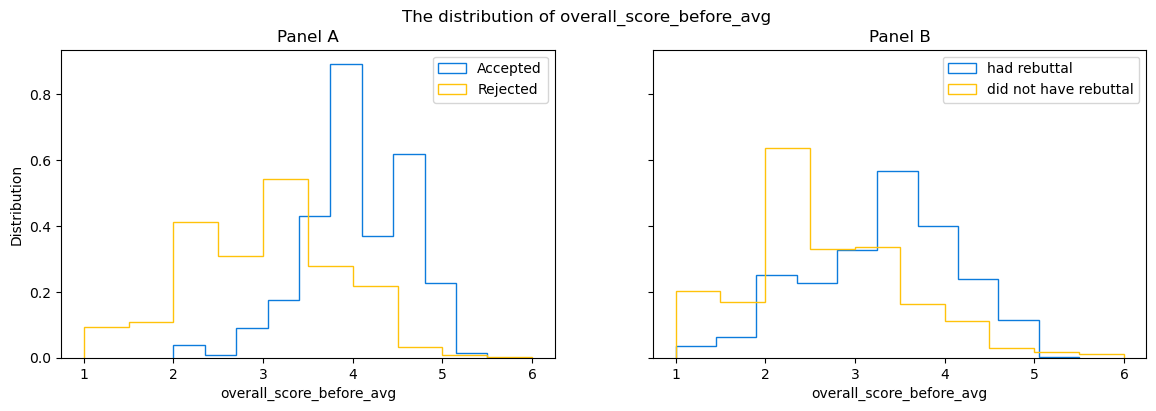

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), sharex=True, sharey=True)
fig.suptitle("The distribution of overall_score_before_avg")

#plotting the histograms/distributions (not cumulative)
axs[0].hist(df_reviews[df_reviews["status"] == "Accept"].overall_score_before_avg, label="Accepted", 
            histtype='step', color='#0C7BDC', density=True)
axs[0].hist(df_reviews[df_reviews["status"] == "Reject"].overall_score_before_avg, label="Rejected", 
            histtype='step', color='#FFC20A', density=True)
axs[0].set(xlabel="overall_score_before_avg", ylabel="Distribution")
axs[0].legend()
axs[0].set_title("Panel A")

axs[1].hist(df_reviews[df_reviews["had_rebuttal"] == True].overall_score_before_avg, label="had rebuttal", 
            histtype='step', color='#0C7BDC', density=True)
axs[1].hist(df_reviews[df_reviews["had_rebuttal"] == False].overall_score_before_avg, label="did not have rebuttal", 
            histtype='step', color='#FFC20A', density=True)
axs[1].set(xlabel="overall_score_before_avg")
axs[1].legend()
axs[1].set_title("Panel B")

plt.show()

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

Knowing that a paper had a rebuttal, the paper's overall score average before will follow the blue curve from panel B. We see that the distribution is slightly left-skewed which means the mode is higher than the mean and so it is more likely for a paper that it got a high score and thus from panel A it's more likely that it was accepted (as the "accepted"/blue curve maximizes the likelihood of having a high score).
This however, doesn't mean that rebuttals help papers get accepted as confounders may be present; in fact the variable `track` can potentially influence the acceptance rate i.e some tracks may have higher acceptance rates than others and also influence the `had_rebuttal` variable in which case the `track` will be a *confounder* and `had_rebuttal` won't cause the papers to get accepted. Another "common sense" reason, is that there's still the **`overall_score_average_after`** that needs to be taken into account. In fact, a paper might get a high score before, then give a rebuttal and get a lower score after and get rejected. This case happened for paper P4. This could happen if for example the rebuttal wasn't of high quality, or if it unveiled a flaw that was previously hidden in the research. 

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [7]:
# Mean of the 'had_rebuttal' variable is the % of rebuttals
rebuttal_perc = df_reviews.groupby("track").had_rebuttal.mean()
#print the rebutalls' percentages per track
display(rebuttal_perc)

track
Dialogue and Interactive Systems                                0.775281
Discourse and Pragmatics                                        0.804348
Document Analysis                                               0.730000
Generation                                                      0.779661
Information Extraction and Text Mining                          0.768362
Linguistic Theories Cognitive Modeling and Psycholinguistics    0.750000
Machine Learning                                                0.808696
Machine Translation                                             0.820755
Multidisciplinary and Area Chair COI                            0.680000
Multilinguality                                                 0.806452
Phonology Morphology and Word Segmentation                      0.851852
Question Answering                                              0.728395
Resources and Evaluation                                        0.732394
Sentence-level semantics                     

We can first assume that the null hypothesis is true i.e. that all tracks have the same fraction of papers with rebuttals. Then, we draw a barplot showing the fraction of papers with rebuttals for each track along with error bars for a 95% confidence interval. If at least 2 intervals are **non-overlapping** (i.e p-value < 0.05 for a 95% ci) then the null hypothesis doesn't explain what we observe and we can reject it.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [8]:
#create the one hot encoder renaming the created columns to what is required i.e {track}-onehot
custom_enc = OneHotEncoder(feature_name_combiner=(lambda x,y: y+'-onehot'))
#fit the encoder to the 'track' column and transform the column  
ohe_track = custom_enc.fit_transform(np.array(df_reviews['track']).reshape(-1,1)).toarray()
#create a pandas df from the one hot encoded representation of the 'track' column
ohe_track_df = pd.DataFrame(ohe_track, columns=custom_enc.get_feature_names_out(['track']))
#update df (i.e remove the track column and replace it with the newly obtained binary features)
df_reviews = pd.concat([df_reviews, ohe_track_df], axis=1)

print(df_reviews.columns)

Index(['tmp_id', 'status', 'submission_type', 'track', 'scores_before',
       'scores_after', 'had_rebuttal', 'overall_score_before_avg',
       'overall_score_after_avg', 'overall_score_before_std',
       'overall_score_after_std', 'Dialogue and Interactive Systems-onehot',
       'Discourse and Pragmatics-onehot', 'Document Analysis-onehot',
       'Generation-onehot', 'Information Extraction and Text Mining-onehot',
       'Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot',
       'Machine Learning-onehot', 'Machine Translation-onehot',
       'Multidisciplinary and Area Chair COI-onehot', 'Multilinguality-onehot',
       'Phonology Morphology and Word Segmentation-onehot',
       'Question Answering-onehot', 'Resources and Evaluation-onehot',
       'Sentence-level semantics-onehot',
       'Sentiment Analysis and Argument Mining-onehot', 'Social Media-onehot',
       'Summarization-onehot', 'Tagging Chunking Syntax and Parsing-onehot',
       'Textual Inferenc


**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [9]:
df_reviews['had_rebuttal_int'] = (df_reviews['had_rebuttal']).astype(int) 
df_reviews['accepted_int'] = (df_reviews['status'] == 'Accept').astype(int)

**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [10]:
def numpy_helper(df, cols):
    '''
    df: a dataframe with N rows
    cols: a list of M columns
    
    return: np.array of dimension (NxM) cast as a float.
    '''
    return np.array(df[cols]).astype(float)


**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [11]:
#creating the X array using the helper function from previous question
cols_X = list(custom_enc.get_feature_names_out(['track'])) + ['overall_score_before_avg', 
                                                              'overall_score_before_std', 'had_rebuttal_int']
X = numpy_helper(df_reviews, cols_X)

#creating the y array using the helper function from previous question
cols_y = ['accepted_int']
y = numpy_helper(df_reviews, cols_y)

#printing the shapes
print("The shape of array X is:", X.shape)
print("The shape of array y is:", y.shape)

The shape of array X is: (1538, 24)
The shape of array y is: (1538, 1)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [15]:
scores_1 = cross_validate(GradientBoostingClassifier(), X[:,:-1], y.ravel(), cv=30, 
                                                          scoring=['accuracy', 'precision', 'recall'])
scores_2 = cross_validate(GradientBoostingClassifier(), X, y.ravel(), cv=30, 
                                                          scoring=['accuracy', 'precision', 'recall'])

# print the average accuracy, precision, and recall across test cross validation splits for model 1
print("Model 1")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_1['test_accuracy'].mean(), scores_1['test_accuracy'].std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_1['test_precision'].mean(), scores_1['test_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_1['test_recall'].mean(), scores_1['test_recall'].std() * 2))

# print the average accuracy, precision, and recall across test cross validation splits for model 2
print("\nModel 2")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_2['test_accuracy'].mean(), scores_2['test_accuracy'].std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_2['test_precision'].mean(), scores_2['test_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_2['test_recall'].mean(), scores_2['test_recall'].std() * 2))


Model 1
Accuracy: 0.84 (+/- 0.08)
Precision: 0.71 (+/- 0.23)
Recall: 0.59 (+/- 0.23)

Model 2
Accuracy: 0.84 (+/- 0.07)
Precision: 0.71 (+/- 0.22)
Recall: 0.60 (+/- 0.23)



**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [16]:
#Running a t-test to compare the accuracy means of models 1 and 2
ttest_ind(scores_1['test_accuracy'], scores_2['test_accuracy'])

Ttest_indResult(statistic=-0.1291661307585383, pvalue=0.897673080747567)

We can see that the p-value is ~ 0.89 > 0.05 which means that the null hypothesis (the 2 mean accuracies are equal) is enough to explain what we observe. Thus, the difference in accurancy of the 2 models is NOT statistically significant.

**2.7** **/Discuss:/** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

In 2.6 we found out that the had_rebuttal variable has no statistically significant influence on the acceptance of a paper which contradicts what we said in task 1 (we said that when a paper had a rebuttal then it is *more likely* to get accepted (note that we didn't say it causes a paper acceptance, but only increases its probability)). 
The advantage the analyses in 2.6 have is that they split the categories of the track feature into separate one hot encoded features while in task 1 we don't. This is better as we've seen that not all tracks have the same rebuttal percentage for papers and thus should be considered separately in our prediction of papers' acceptance.

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regressions. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [19]:
# perform ols regression helper function
def ols_regression(df: pd.DataFrame, formula: str) -> None:
    """
    Computes the OLS regression for the given formula and dataframe,
    and reports the results.
    :param df: the dataframe to use
    :param formula: the formula to use
    :return: None
    """
    # create a fitted model
    mod = smf.ols(formula=formula, data=df)
    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(2)
    res = mod.fit()
    # Print the summary output provided by the library.
    print(res.summary())

In [20]:
ols_regression(df_reviews, 'accepted_int ~ had_rebuttal_int')

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.24e-16
Time:                        16:23:25   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0838      0.023  

**Answer:**
`accepted_int` = 0.0838 + 0.2098 * `had_rebuttal_int`

In [21]:
ols_regression(df_reviews, 'accepted_int ~ overall_score_after_avg')

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          1.58e-173
Time:                        16:23:25   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Answer:**
`accepted_int` = 0.1651 + 0.2860 * `overall_score_after_avg`

In [22]:
ols_regression(df_reviews, 'had_rebuttal_int ~ overall_score_before_avg')

                            OLS Regression Results                            
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.89e-50
Time:                        16:23:25   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

**Answer:**
`had_rebuttal_int` = 0.2527 + 0.1651 * `overall_score_before_avg`


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variable in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



The coefficient asscociated with the binary independent variable `had_rebuttal_int` (i.e the slope) in the formula `accepted_int ~ had_rebuttal_int` is the difference in mean outcomes (i.e mean acceptance rate) between data points with `had_rebuttal_int` = 1 and data points with `had_rebuttal_int` = 0. For instance, papers with `had_rebuttal_int` = 0 have a mean `accepted_int` of 0.0838 (the intercept) (almost 0 acceptance!) while papers with `had_rebuttal_int` = 1 have a mean `accepted_int` of 0.0838 (the intercept) + 0.2098 (the slope) = 0.2936 (~30% acceptance rate)


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


We can see that `accepted_int` is positively correlated with `had_rebuttal_int` as `had_rebuttal_int`'s coefficient (0.2098) is positive and its p-value is 0 < 0.05 so it's statistically significant. This means that a higher value of `had_rebuttal_int` corresponds to a higher value of `accepted_int`.
Similarly, we see that `accepted_int` is positively correlated with `overall_score_after_avg` as `overall_score_after_avg`'s coefficient (0.2860) is positive and its p-value is 0 < 0.05 so it's statistically significant. This means that a higher value of `overall_score_after_avg` corresponds to a higher value of `accepted_int`.
Likewise, we see that `had_rebuttal_int` is positively correlated with `overall_score_before_avg` as `overall_score_before_avg`'s coefficient (0.1651) is positive and its p-value is 0 < 0.05 so it's statistically significant. This means that a higher value of `overall_score_before_avg` corresponds to a higher value of `had_rebuttal_int`.

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


True. Explanation: $R^2$ represents the fraction of variance explained by the model. We see that `overall_score_after_avg` explains more of the variance in `accepted_int` than the variable `overall_score_before_avg` explains of `had_rebuttal_int` as the $R^2$ of the former model (0.402) is higher than the $R^2$ of the latter model (0.135).


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

#### **Answer:**
- Tr->Sb
- Tr->Ac
- Tr->Re
- Sb->Ac
- Sb->Re
- Sb->Sa 
- Sa->Ac
- Re->Ac
- Re->Sa

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

The problem with simply comparing the outcomes of papers that had rebuttals with those that did not is that there might be a confounder that we are not taking into consideration that may be leading us to false\
conclusions about wheter rebuttals influence acceptance or not.
For instance, we might think that rebuttals influence acceptance but in fact the track of the paper might be the confounder.\
In fact, some tracks might have a higher acceptance rate than others and also have a higher rebuttal rate than others. In this case, the track is a confounder as it influences both the rebuttal rate and the acceptance rate and thus we can't say that rebuttals influence acceptance.\
To come up with a more robust conclusion about the causal relationship between rebuttals and acceptance, we need to control for confounders.\

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [23]:
# Exact matching when the treatment and control are exact same on average score and track
# Select the treatment/control groups 
treatment_df = df_reviews[df_reviews['had_rebuttal_int']==1]
control_df = df_reviews[df_reviews['had_rebuttal_int']==0]

# Create Graph
G = nx.Graph()

# Add an edge with a weight of 1 when the control and treatment groups have the exact same average score and track
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        if (control_row['track'] == treatment_row['track']) & \
        (control_row['overall_score_before_avg'] == treatment_row['overall_score_before_avg']):
            G.add_weighted_edges_from([(control_id, treatment_id, 1)])

# Get at most one matched node for each node, maximizing the total weight of matched edges
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

# Select the matched pairs only
df_matched = df_reviews.loc[matched]
display(df_matched)

,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_after_avg,overall_score_before_std,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
1515,P1523,Reject,Long,Document Analysis,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,3.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
595,P597,Reject,Short,Machine Translation,"{'3': {'scores': {'originality': 3, 'soundness...","{'3': {'scores': {'originality': 3, 'soundness...",True,2.000000,2.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
669,P672,Reject,Long,Information Extraction and Text Mining,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,1.500000,1.500000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
351,P353,Reject,Long,Summarization,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,3.333333,3.333333,0.471405,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
270,P271,Reject,Long,Phonology Morphology and Word Segmentation,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,2.333333,2.333333,0.471405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,P370,Reject,Short,Sentence-level semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.000000,2.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
475,P477,Reject,Long,Sentence-level semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,2.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
416,P418,Reject,Long,Textual Inference and Other Areas of Semantics,"{'2': {'scores': {'originality': 3, 'soundness...","{'2': {'scores': {'originality': 3, 'soundness...",False,2.500000,1.500000,1.500000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
591,P593,Reject,Long,Resources and Evaluation,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,2.333333,1.699673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


**4.2** So far, we did not consider the `score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [24]:
# select the treatment/control groups of the matched dataset
treatment_df_match = df_matched[df_matched['had_rebuttal_int']==1]
control_df_match = df_matched[df_matched['had_rebuttal_int']==0]

# compute smd
smd = np.abs(np.mean(treatment_df_match['overall_score_before_std']) - \
             np.mean(control_df_match['overall_score_before_std'])) / \
      np.sqrt(np.var(treatment_df_match['overall_score_before_std']) + \
              np.var(control_df_match['overall_score_before_std']))
print('SMD: {0:.5}'.format(smd))

SMD: 0.07632


**Answer:**
We see that smd=0.07632 < 0.1, which suggests that the `overall_score_before_std` is balanced across the 2 groups.


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [25]:
# estimate the linear regression using ols module
ols_regression(df_matched, 'accepted_int ~ had_rebuttal_int')

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07696
Date:                Fri, 01 Dec 2023   Prob (F-statistic):              0.782
Time:                        16:23:58   Log-Likelihood:                -132.72
No. Observations:                 542   AIC:                             269.4
Df Residuals:                     540   BIC:                             278.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1033      0.019  

**Answer:**
`accepted_int` = 0.1033 + 0.0074 * `had_rebuttal_int`


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

**Answer:**

i. Because the coefficient of `had_rebuttal_int` is very small and its corresponding pvalue > 0.05, we can say that rebuttals don't affect the acceptance of the paper.

Here the result is different than what we observed in task 1, because in task 1 we studied the correalation between acceptance and rebuttal directly without considering any confounders. However, `overall_score_before_avg` and `track` are influencing both the rebuttals and acceptance and are confounders. So, here we have balanced papers with and without rebuttals, making the `overall_score_before_avg` and `track` on both groups, and found that having rebuttals does not influence the acceptance of the paper.

ii. Because we have balanced the dataset on `track`, `overall_score_before_avg` and given that the matched dataset was already balanced on `overall_score_before_std`, they don't affect the `accepted_int` directly.

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac 

Assume that

- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.

Does this uncontrolled confounder threaten the validity of your findings?


**Answer:**

- Before in Task 3.5 we had put the correlation Re -> Ac, as we were still studying it, however after matching the control/treatment groups, we saw that there is actually no direct correlation, but it was because of the presense of confounders `overall_score_before_avg` (Sb) and `track` (Tr). Our finding is that **having a rebuttal does not cause the paper to be accepted.**

- The fact that we don't have a correlation Sa -> Re, and we have removed the correlation Sb -> Re by matching the control/treatment group on `overall_score_before_avg` means the correlations Qu -> Sa and Qu -> Sb do not affect our study of the correlation between Re and Ac.

- Because "Qu" is influencing both Re and Ac, it is an additional confounder that we are not considering in our analysis, so by considering the Quality of the paper, maybe we could have found a direct correlation (meaning causation) between `had_rebuttal_int` and `accepted_int`. However, because the increase of the chance of a paper's acceptance is caused by quality and rebuttal, and the increase of the chances of rebuttals is caused by quality, the increase of the chance of a paper's acceptance might be caused by the quality only, and not be influenced by the rebuttals directly. We could study it by matching on `Quality` as well, if that is the case, it would not have invalidated our current findings.